In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
DATASET_PATH = "./data"
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

2023-08-01 15:11:29.958278: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 15:11:30.011713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 15:11:32.951180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]
Files already downloaded and verified


In [2]:
val_loader   = data.DataLoader(val_set,
                               batch_size=256,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
gt = []
for x in val_loader:
    gt.append(x[1])
gt = np.concatenate(gt,axis = 0)

In [3]:
baseline = pd.read_csv('baseline.csv').to_numpy().reshape((5000,))
np.mean(baseline==gt)


0.919

In [35]:
frames_5 = {} 
for i in range(15):
    frames_5[i] = pd.read_csv(f'./predictions/resnet_0.5_{i}_set.csv').to_numpy()
frames_6 = {} 
for i in range(15):
    frames_6[i] = pd.read_csv(f'./predictions/resnet_0.6_{i}_set.csv').to_numpy()
frames_7 = {} 
for i in range(15):
    frames_7[i] = pd.read_csv(f'./predictions/resnet_0.7_{i}_set.csv').to_numpy()
frames_8 = {} 
for i in range(15):
    frames_8[i] = pd.read_csv(f'./predictions/resnet_0.8_{i}_set.csv').to_numpy()
frames_9 = {} 
for i in range(15):
    frames_9[i] = pd.read_csv(f'./predictions/resnet_0.9_{i}_set.csv').to_numpy()


In [14]:
seed_dis = np.zeros((15,10))
for i in range(15):
    for j in range(10):
        pos = np.where(baseline == j)
        seed_dis[i,j] = np.mean(frames[i][:,-1][pos] != j)

In [15]:
print(np.std(seed_dis,axis = 0), '\n',np.mean(seed_dis ,axis = 0))

[0.01441798 0.01302317 0.01546248 0.03755056 0.02297229 0.02122889
 0.01301567 0.02530224 0.00978728 0.01321069] 
 [0.12053743 0.03868809 0.15954631 0.25625823 0.1047619  0.18493248
 0.04852234 0.10595691 0.04928717 0.05990903]


In [16]:
from scipy.stats import spearmanr as spr
from sklearn import preprocessing as p
# !pip install sklearn
mms = p.MinMaxScaler()


In [17]:
sprmat = np.zeros((15,15))
for i in range(15):
    for j in range(15):
        x1 = mms.fit_transform(seed_dis[i].reshape(-1,1)).reshape(-2,)
        x2 = mms.fit_transform(seed_dis[j].reshape(-1,1)).reshape(-2,)
        sprmat[i,j] = spr(x1,x2)[0]

In [25]:
print(sprmat)

[[1.         0.93939394 0.93939394 0.96363636 0.9030303 ]
 [0.93939394 1.         0.96363636 0.92727273 0.89090909]
 [0.93939394 0.96363636 1.         0.97575758 0.85454545]
 [0.96363636 0.92727273 0.97575758 1.         0.84242424]
 [0.9030303  0.89090909 0.85454545 0.84242424 1.        ]]


<Axes: title={'center': 'Rank correlation'}>

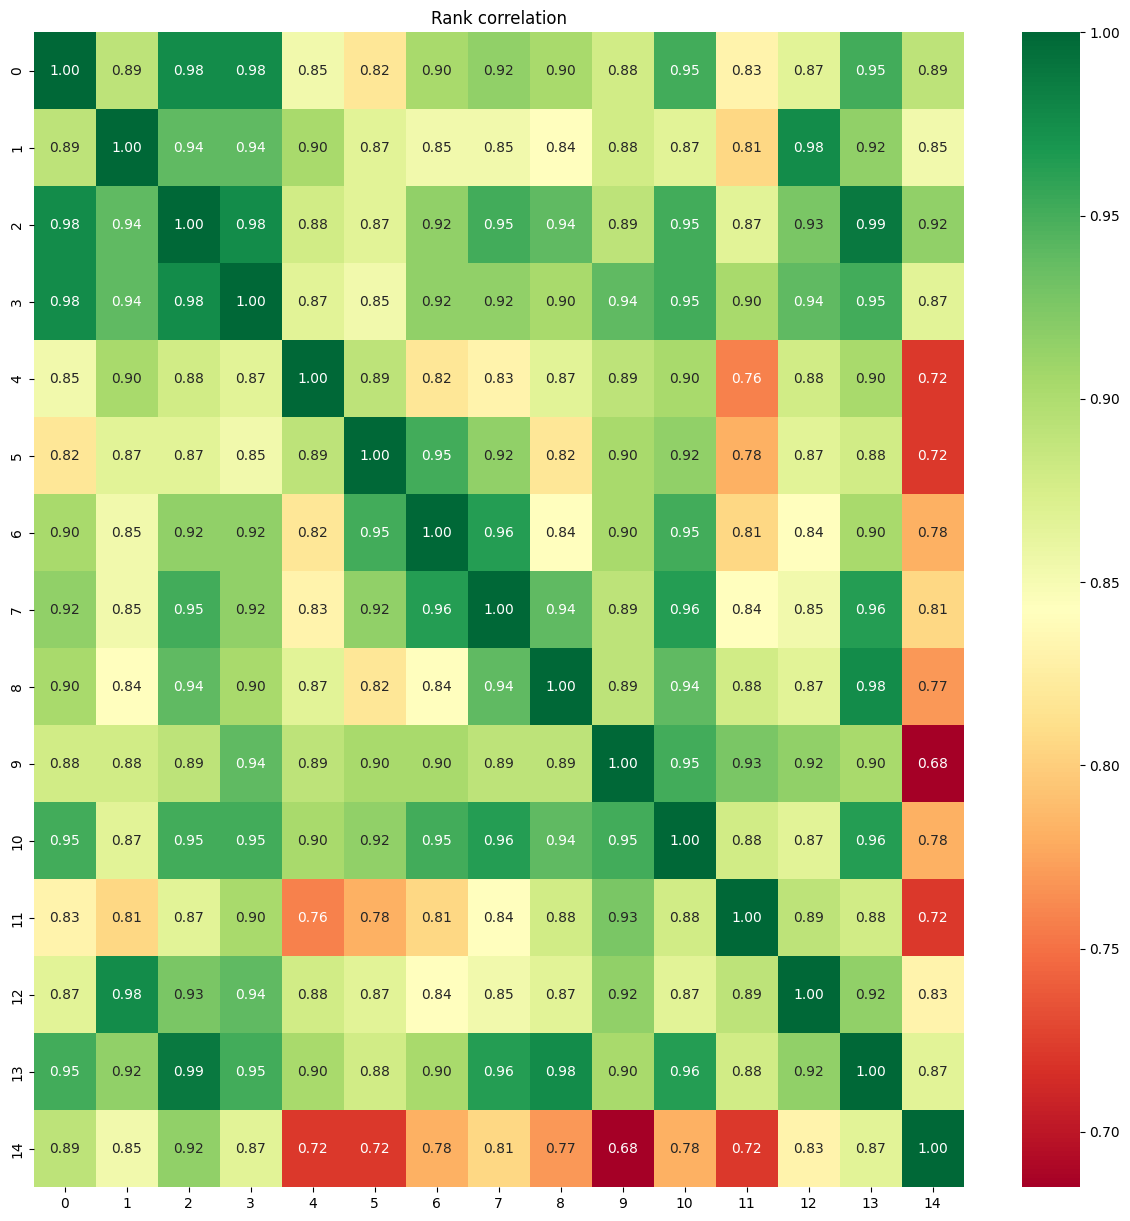

In [18]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Rank correlation')
sns.heatmap(sprmat, annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

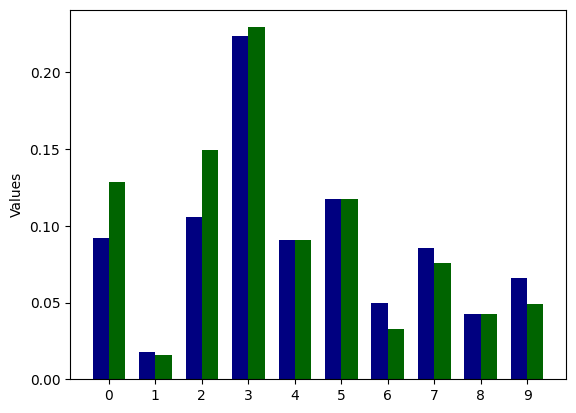

In [19]:
import matplotlib.pyplot as plt
keys = [0,1,2,3,4,5,6,7,8,9]
values1 = list(seed_dis[1])
values2 = list(seed_dis[0])
bar_width = 0.35
fig, ax = plt.subplots()
for i in range(len(keys)):
    x_pos = i
    ax.bar(x_pos - bar_width/2, values1[i], bar_width,color='navy', label='Scratch')
    ax.bar(x_pos + bar_width/2, values2[i], bar_width, color='darkgreen',label='Distiller')
    ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys)
ax.set_ylabel('Values')
plt.show()

In [53]:
confmat  = np.zeros((5,15,10,10),dtype = np.int32)

In [54]:
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_5[i][j,-1]):
         confmat[0,i,gt[j],frames_5[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_6[i][j,-1]):
         confmat[1,i,gt[j],frames_6[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_7[i][j,-1]):
         confmat[2,i,gt[j],frames_7[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_8[i][j,-1]):
         confmat[3,i,gt[j],frames_8[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_9[i][j,-1]):
         confmat[4,i,gt[j],frames_9[i][j,-1]]+=1


<Axes: title={'center': ' Mean Disagreement sparsity = 0.5'}>

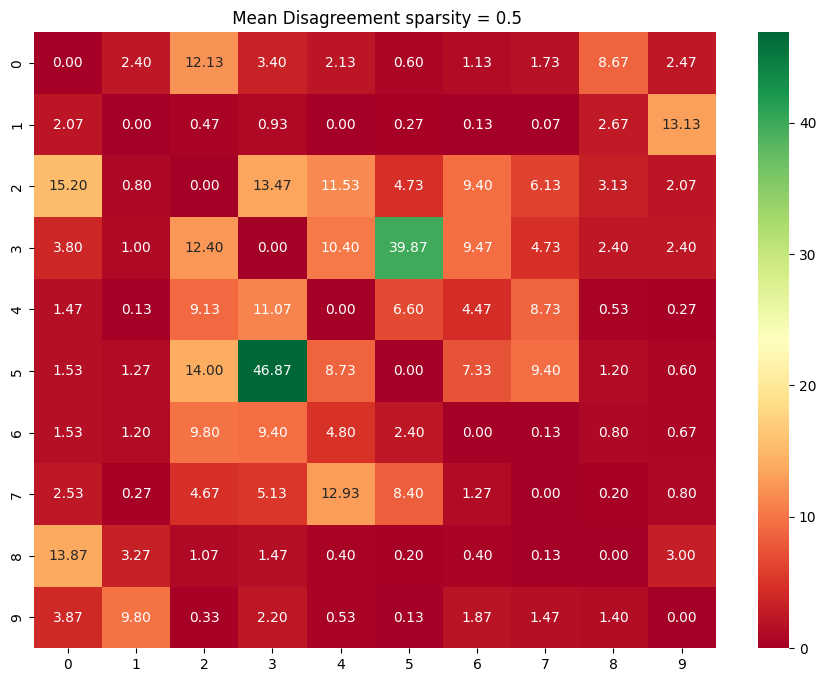

In [56]:

a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{5}')
sns.heatmap(np.mean(confmat[0],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.6'}>

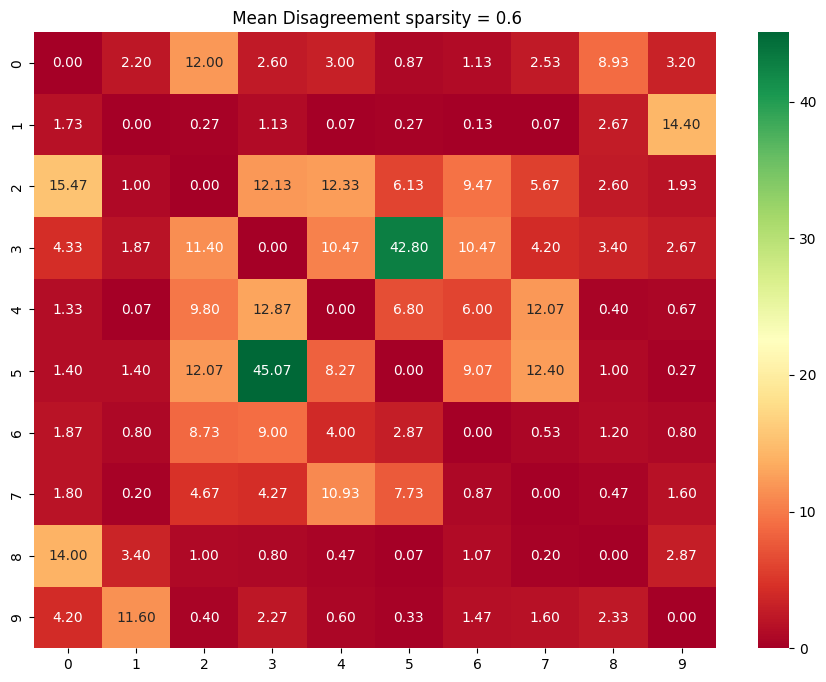

In [57]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{6}')
sns.heatmap(np.mean(confmat[1],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.7'}>

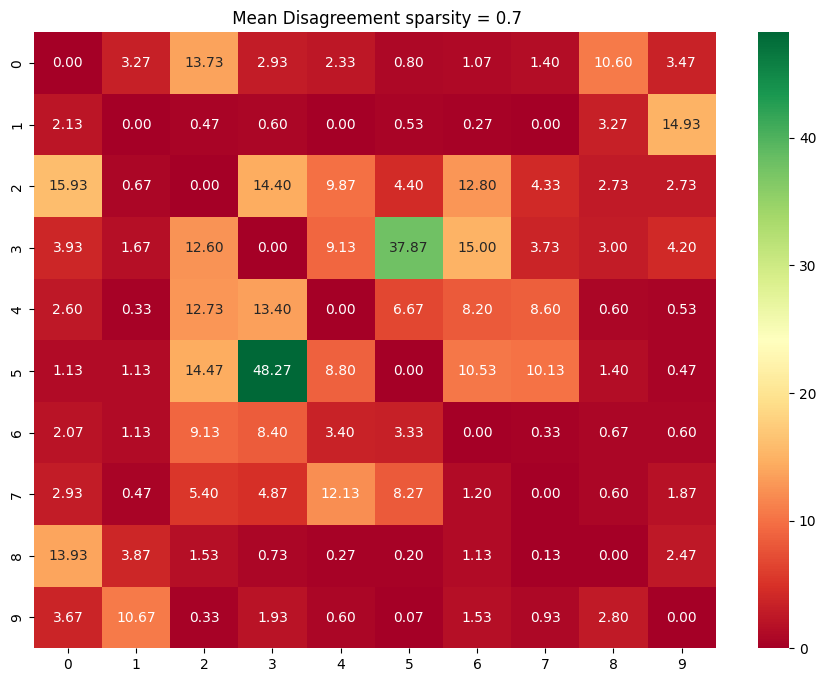

In [58]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{7}')
sns.heatmap(np.mean(confmat[2],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.8'}>

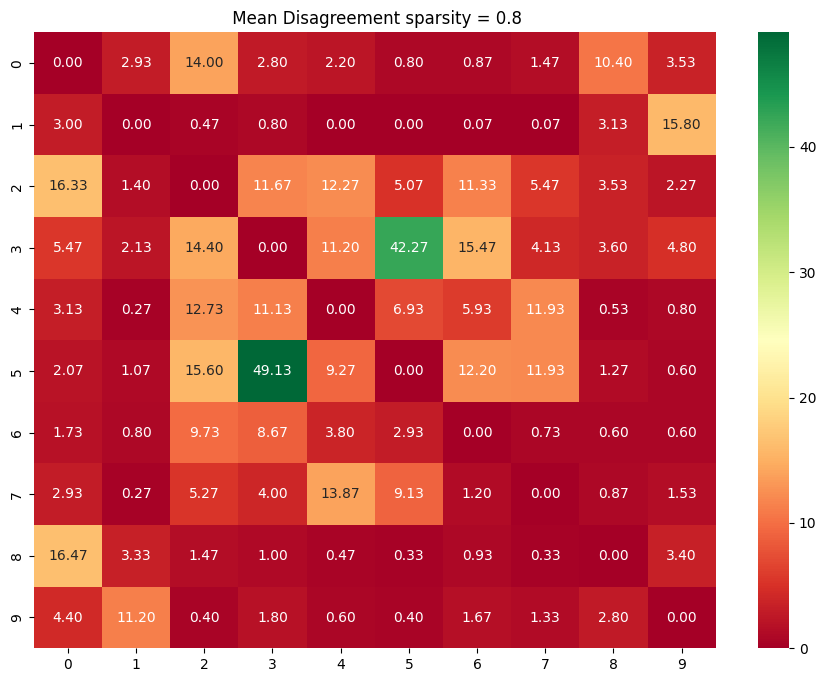

In [59]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{8}')
sns.heatmap(np.mean(confmat[3],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.9'}>

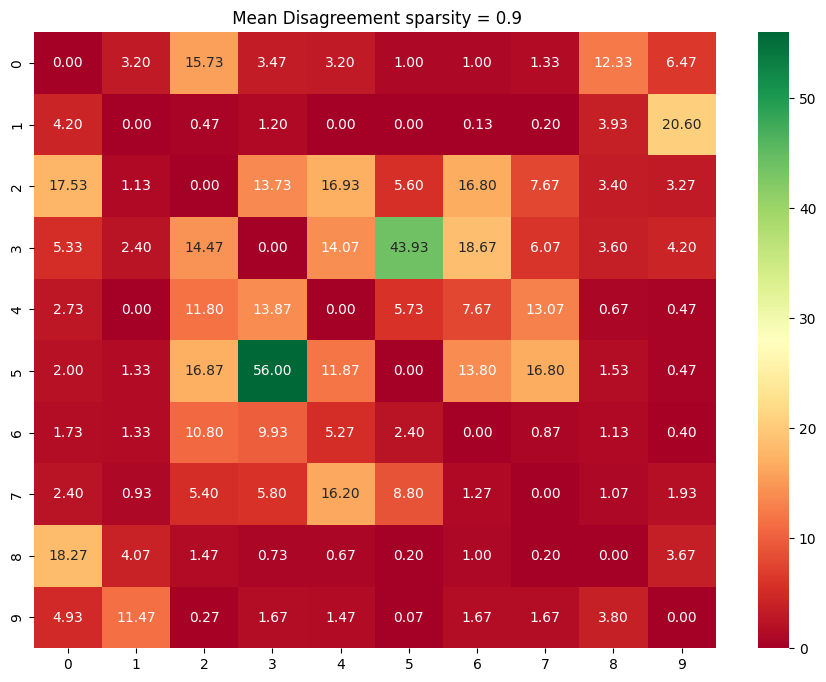

In [60]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{9}')
sns.heatmap(np.mean(confmat[4],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

In [ ]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' sparsity = 0.{8}')
sns.heatmap(np.mean(confmat,axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

In [108]:
fpfn = np.zeros((5,10,2))
for i in range(5):
    for j in range(10):
        fpfn[i,j,0] = np.sum(confmat[i,:,j])
        fpfn[i,j,1] = np.sum(confmat[i,j,:])

In [109]:
confmat_baseline = np.zeros((10,10))
fpfn_baseline  = np.zeros((10,2))
for i in range(5000):
    if(gt[i]!=baseline[i]):
        confmat_baseline[gt[i],baseline[i]]+=1
for i in range(10):
    fpfn_baseline[i,0] = np.sum(confmat_baseline[:,i])
    fpfn_baseline[i,1] = np.sum(confmat_baseline[i,:])


In [110]:
diff_array = np.zeros((5,10,2))
for i in range(5):
    diff_array[i] = fpfn[i] - fpfn_baseline
    diff_array[i] = np.divide(diff_array[i], fpfn_baseline)*100

In [111]:
classwise_means = np.mean(diff_array,axis = 1)

In [112]:
cev_n = np.mean((diff_array - classwise_means.reshape((5,1,2)))**2,axis = 1)
# cev_n = np.zeros((5,2))
# for i in range(5):
#     cev_n[i] = np.mean((diff_array[i] - classwise_means[i])**2,axis = 0)

In [20]:
def create_plot(frames):
    sh = frames.shape[1]
    print(sh)
    x = np.zeros((sh//10,sh//10))
    for i in range(0,sh,10):
        for j in range(0,sh,10):
         
            x[i//10,j//10] = np.mean(frames[:,i]!=frames[:,j])
    return x;

In [35]:
out = create_plot(frames[5])

200


In [36]:
out.shape

(20, 20)

200
200
200
200
200


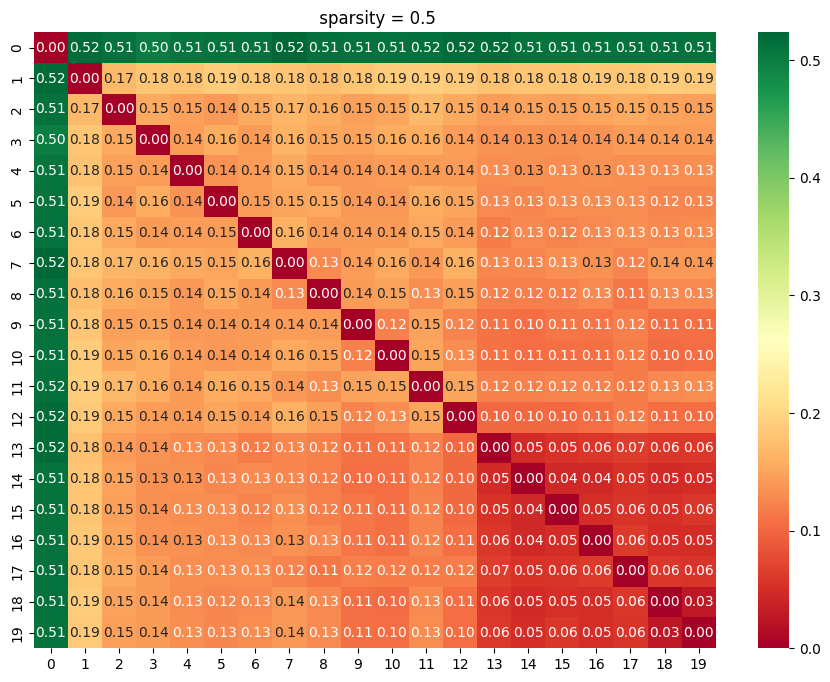

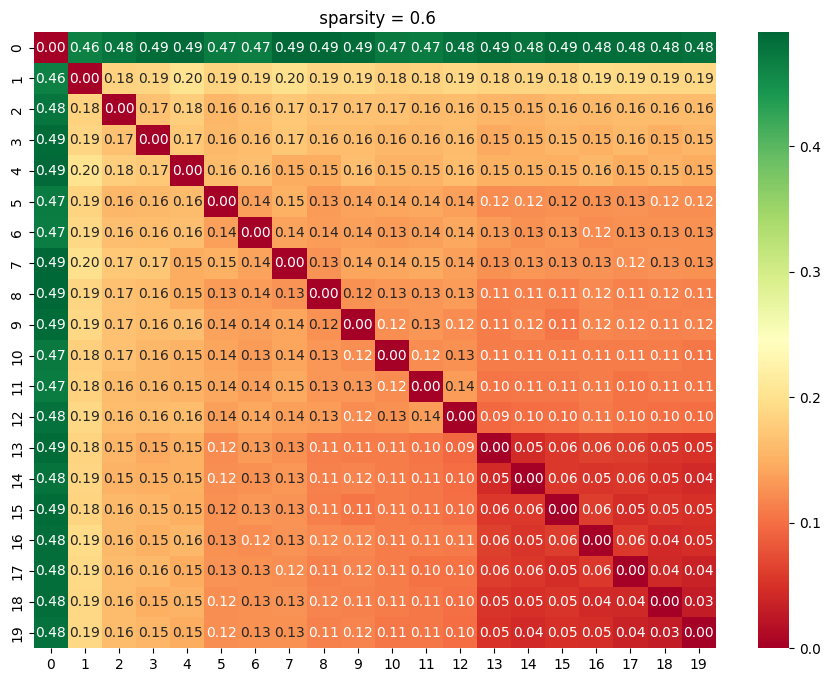

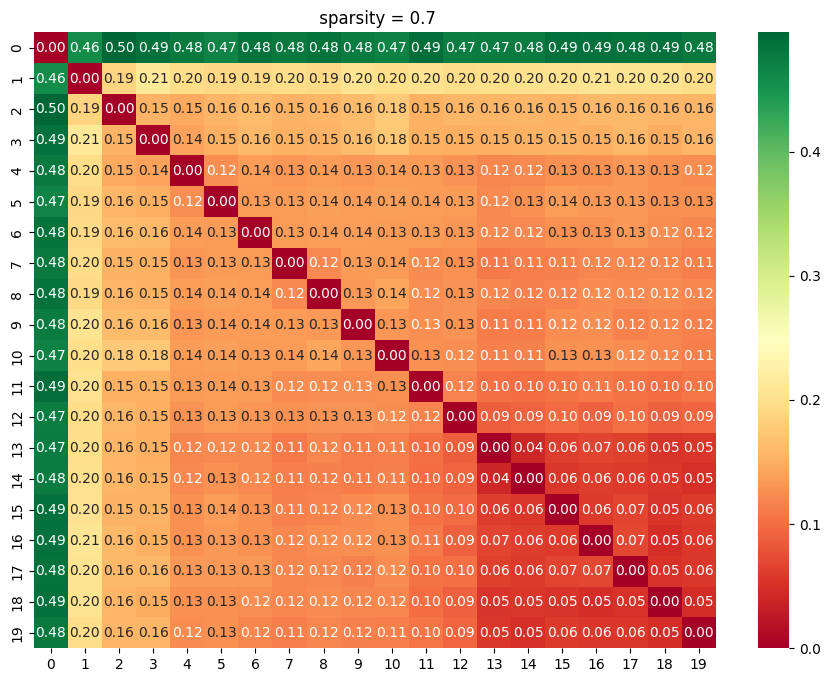

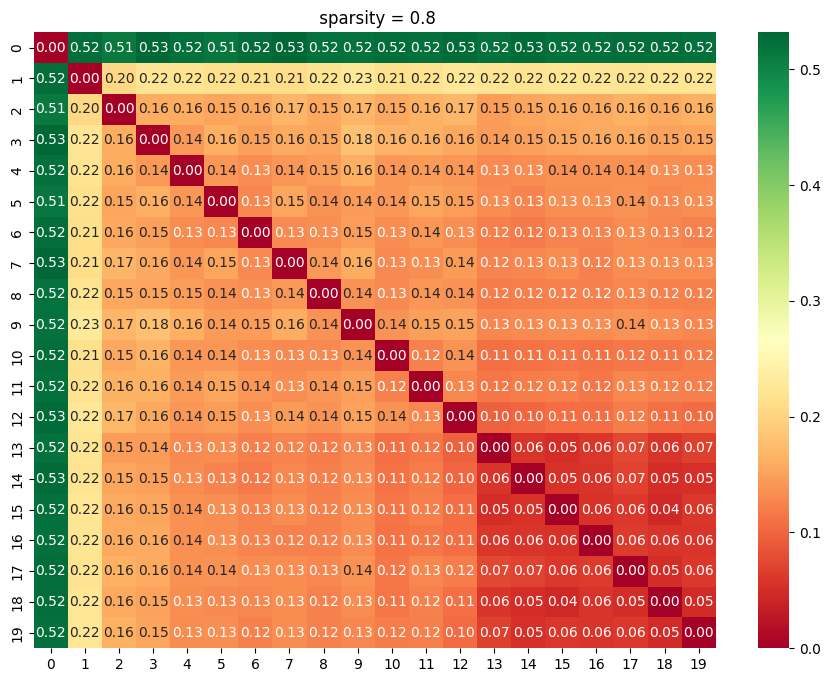

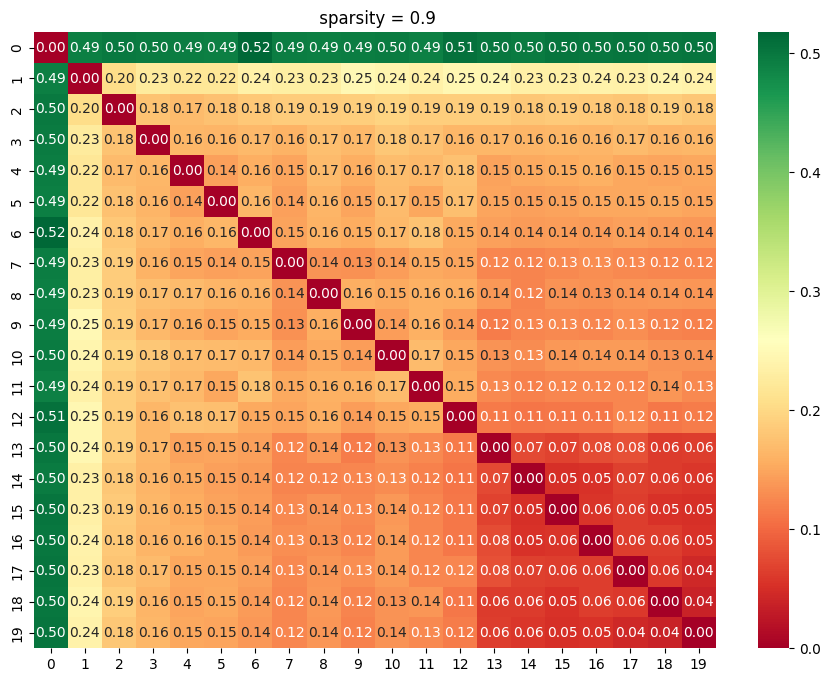

In [21]:
# plt.imshow(out, cmap='autumn', interpolation='nearest')
 
# # Add colorbar
# plt.colorbar()
 
# plt.title("Heatmap with color bar")
# plt.show()
for i in range(5,10,1):
    out = create_plot(frames[i])
    a4_dims = (11, 8)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title(f' sparsity = 0.{i}')
    sns.heatmap(out, annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

In [14]:
baseline = pd.read_csv('resnet_0.5_0.csv').to_numpy()[:,-1]
classwise_dis = np.random.randn(5,10)
for i in range(5,10,1):
    for j in range(10):
        k = np.where(baseline == j)
       
        classwise_dis[i-5,j] = np.mean(frames[i][k,-1]!=baseline[k])

In [15]:
classwise_dis

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07610994, 0.03675048, 0.11545988, 0.16775599, 0.12681913,
        0.19230769, 0.09245283, 0.08267717, 0.06986028, 0.10646388],
       [0.06553911, 0.05415861, 0.11545988, 0.16339869, 0.14553015,
        0.15789474, 0.08679245, 0.08858268, 0.07984032, 0.08174905],
       [0.0782241 , 0.07930368, 0.12720157, 0.20697168, 0.14553015,
        0.1437247 , 0.10377358, 0.10433071, 0.05189621, 0.07984791],
       [0.08668076, 0.04448743, 0.14872798, 0.21786492, 0.15800416,
        0.1659919 , 0.0754717 , 0.1023622 , 0.0738523 , 0.10456274]])

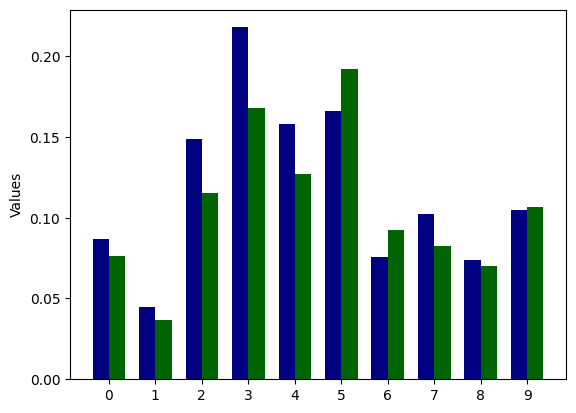

In [19]:
import matplotlib.pyplot as plt
keys = [0,1,2,3,4,5,6,7,8,9]
values1 = list(classwise_dis[4,:])
values2 = list(classwise_dis[1,:])
bar_width = 0.35
fig, ax = plt.subplots()
for i in range(len(keys)):
    x_pos = i
    ax.bar(x_pos - bar_width/2, values1[i], bar_width,color='navy', label='Scratch')
    ax.bar(x_pos + bar_width/2, values2[i], bar_width, color='darkgreen',label='Distiller')
    ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys)
ax.set_ylabel('Values')
plt.show()